<h1><center>Sample design - Stress/Strain anisotropy tester</center></h1>

### Parameters for file to test

This is the **only section** you must edit !

For the constitutive model, you may choose between :
- '1-tanhplastic'
- '2-perfectplasticity'


In [1]:
# list available samples
from os import listdir
meshpath = './resultstester_GAP/'
mesh_list = [x for x in listdir(meshpath) if x.endswith('.xdmf')]

mesh_list

['2hole.xdmf',
 '2notch.xdmf',
 'test_array_ellipse.xdmf',
 'test_clover.xdmf',
 'test_clover_rand.xdmf',
 'test_loop_array_2fold.xdmf',
 'test_loop_array_3fold.xdmf',
 'test_NPR.xdmf',
 'test_NPR_rounded.xdmf',
 'test_NPR_rounded_45.xdmf',
 'test_NPR_rounded_90.xdmf',
 'test_NPR_rounded_h.xdmf',
 'test_NPR_rounded_rand.xdmf',
 'test_NPR_rounded_swivel.xdmf',
 'test_NPR_rounded_v.xdmf',
 'test_simplehole_discA1.xdmf',
 'test_simplehole_ellipseA12.xdmf',
 'test_simplehole_rectangleA12.xdmf',
 'test_simplehole_squareA1.xdmf',
 'test_simplehole_squareB1.xdmf',
 'test_withouthole.xdmf']

In [2]:
mesh_list = [
'2hole.xdmf',
 '2notch.xdmf',
 'test_array_ellipse.xdmf',
 'test_clover.xdmf',
#  'test_clover_rand.xdmf',
#  'test_loop_array_2fold.xdmf',
#  'test_loop_array_3fold.xdmf',
#  'test_NPR.xdmf',
 'test_NPR_rounded.xdmf',
 'test_NPR_rounded_45.xdmf',
#  'test_NPR_rounded_90.xdmf',
#  'test_NPR_rounded_rand.xdmf',
#  'test_NPR_rounded_swivel.xdmf',
#  'test_NPR_rounded_h.xdmf',
#  'test_NPR_rounded_v.xdmf',
 'test_simplehole_discA1.xdmf',
 'test_simplehole_ellipseA12.xdmf',
 'test_simplehole_rectangleA12.xdmf',
 'test_simplehole_squareA1.xdmf',
 'test_simplehole_squareB1.xdmf',
 'test_withouthole.xdmf'
]

In [3]:
import re

mesh_list_simple = mesh_list.copy()
for i in range(len(mesh_list_simple)):
    mesh_list_simple[i] = re.sub('.xdmf','',mesh_list_simple[i])
    mesh_list_simple[i] = re.sub('test_','',mesh_list_simple[i])
#     mesh_list_simple[i] = re.sub('_',' ',mesh_list_simple[i])
    mesh_list_simple[i] = re.sub('simplehole_','',mesh_list_simple[i])
    mesh_list_simple[i] = re.sub('NPR','bowtie',mesh_list_simple[i])
    
mesh_list_simple

['2hole',
 '2notch',
 'array_ellipse',
 'clover',
 'bowtie_rounded',
 'bowtie_rounded_45',
 'discA1',
 'ellipseA12',
 'rectangleA12',
 'squareA1',
 'squareB1',
 'withouthole']

In [4]:
#Test loading profile
T_max = 40                                    #loading time length (s)
e_max = 0.005                                   #max upper boundary strain (no unit)
nb_steps = 15                                 #number of time steps during loading (default is 10)

In [5]:
# Mechanical Properties for sample design evaluation
# (default is given for steel https://www.matweb.com/search/datasheet.aspx?bassnum=MS0001&ckck=1 )

E_float = 200*1e9                                     #Young modulus (Pa)        default 200*1e9
nu_float = 0.25                                       #Poisson ratio (no unit)   default 0.25
sigma_y0_float = 350*1e6                              #Yield stress (Pa)         default 350*1e6

#MODEL PARAMETERS :
    #1-tanhplastic
sp=10
amp=0.1
    #2-perfectplasticity
#no parameters to define
    #3-

In [6]:
# To change the number of discrete segments to calculate anisotropy score :
# (default is 200)
n_seg=200
rel_thresh=1/3

In [7]:
from fenics import *
from dolfin_adjoint import *
# import pygmsh_mesh_functions
# from pygmsh_mesh_functions import *
import meshio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# For quality evaluation
from anisotropyv3 import GapScore
from anisotropy_density import *

from scipy.io import loadmat

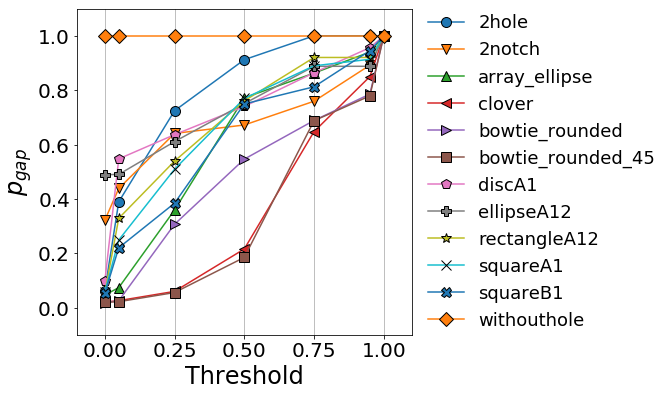

In [8]:
from matplotlib.lines import Line2D
markers_list = ["o","v","^","<",">","s","p","P","*","x","X","D","d","+","|","_",0,1,2,3,4,5,6,7,8,9,10,11
]

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)
ax.set_xlim(-.1, 1.1)
ax.set_ylim(-.1, 1.1)
ax.set_xticks(np.array([1.00,0.75,0.50,0.25,0.0]))
# ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1]))
ax.set_xlabel('Threshold',fontsize=24)
ax.set_ylabel(r'$p_{gap}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
# ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)
ax.grid(visible=True, which='major', axis='x')

lines = []
for i in range(len(mesh_list)):
    #### Meshfile ####
    meshfile = mesh_list[i]                    # with .xdmf
    meshpath = './output_files/'
    
    #### Evaluate strain diversity ####
    # load data
    filename = './resultstester_GAP/'+meshfile+'/'+'score.mat'
    Score_density = loadmat(filename)['Score_density']
    Score_radius = loadmat(filename)['Score_radius']
    Score_h = loadmat(filename)['Score_h']
    Score_gap = loadmat(filename)['Score_gap']
    
    thresholds = [1.00, 0.95, 0.75, 0.50, 0.25, 0.05, 0.00]
    lines.append(ax.plot(thresholds,Score_gap[0], '-', 
                         marker=markers_list[i], markersize=10, markeredgecolor='k',
                         label=mesh_list_simple[i]))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.75, box.height])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5),frameon=False,fontsize=18)
# ax.legend(lines,mesh_list_simple)

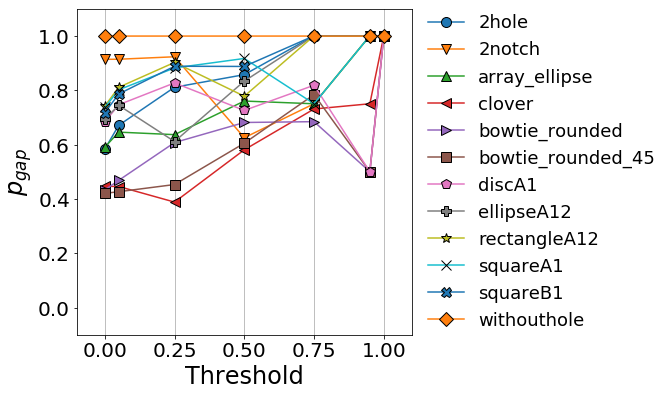

In [9]:
from matplotlib.lines import Line2D
markers_list = ["o","v","^","<",">","s","p","P","*","x","X","D","d","+","|","_",0,1,2,3,4,5,6,7,8,9,10,11
]

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)
ax.set_xlim(-.1, 1.1)
ax.set_ylim(-.1, 1.1)
ax.set_xticks(np.array([1.00,0.75,0.50,0.25,0.0]))
# ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1]))
ax.set_xlabel('Threshold',fontsize=24)
ax.set_ylabel(r'$p_{gap}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
# ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)
ax.grid(visible=True, which='major', axis='x')

lines = []
for i in range(len(mesh_list)):
    #### Meshfile ####
    meshfile = mesh_list[i]                    # with .xdmf
    meshpath = './output_files/'
    
    #### Evaluate strain diversity ####
    # load data
    filename = './resultstester_GAP/'+meshfile+'/'+'score.mat'
    Score_density = loadmat(filename)['Score_density']
    Score_radius = loadmat(filename)['Score_radius']
    Score_h = loadmat(filename)['Score_h']
    Score_gap = loadmat(filename)['Score_gap']
    Score_uniformity = loadmat(filename)['Score_uniformity']
    
    thresholds = [1.00, 0.95, 0.75, 0.50, 0.25, 0.05, 0.00]
    lines.append(ax.plot(thresholds,Score_uniformity[0], '-', 
                         marker=markers_list[i], markersize=10, markeredgecolor='k',
                         label=mesh_list_simple[i]))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.75, box.height])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5),frameon=False,fontsize=18)
# ax.legend(lines,mesh_list_simple)

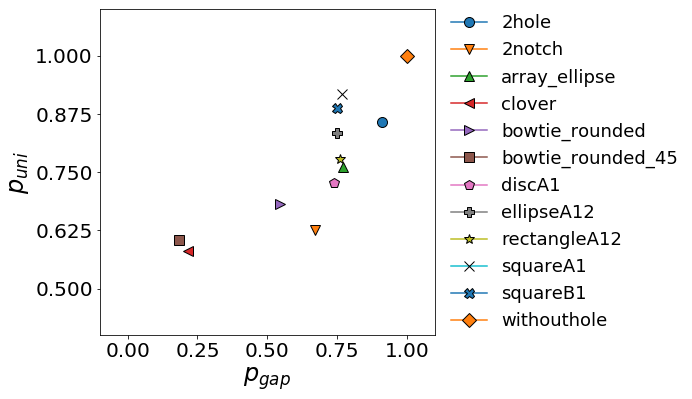

In [10]:
from matplotlib.lines import Line2D
markers_list = ["o","v","^","<",">","s","p","P","*","x","X","D","d","+","|","_",0,1,2,3,4,5,6,7,8,9,10,11
]

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)
ax.set_xlim(-.1, 1.1)
ax.set_ylim(.4, 1.1)
ax.set_xticks(np.array([1.0,0.75,0.50,0.25,0.0]))
ax.set_yticks(np.array([1.0,0.75,0.50,0.25,0.0])/2+0.5)
ax.set_xlabel(r'$p_{gap}$',fontsize=24)
ax.set_ylabel(r'$p_{uni}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
# ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)
# ax.grid(visible=True, which='major', axis='x')
# ax.set_yscale('log')

lines = []
for i in range(len(mesh_list)):
    #### Meshfile ####
    meshfile = mesh_list[i]                    # with .xdmf
    meshpath = './output_files/'
    
    #### Evaluate strain diversity ####
    # load data
    filename = './resultstester_GAP/'+meshfile+'/'+'score.mat'
    Score_density = loadmat(filename)['Score_density']
    Score_radius = loadmat(filename)['Score_radius']
    Score_h = loadmat(filename)['Score_h']
    Score_gap = loadmat(filename)['Score_gap']
    Score_uniformity = loadmat(filename)['Score_uniformity']
    
    thresholds = [1.00, 0.95, 0.75, 0.50, 0.25, 0.05, 0.00]
    lines.append(ax.plot(Score_gap[0,3],(Score_uniformity[0,3]), '-', 
                         marker=markers_list[i], markersize=10, markeredgecolor='k',
                         label=mesh_list_simple[i]))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.75, box.height])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5),frameon=False,fontsize=18)
# ax.legend(lines,mesh_list_simple)

In [19]:
# sorting
scores = []
for i in range(len(mesh_list)):
    
    #### Meshfile ####
    meshfile = mesh_list[i]                    # with .xdmf
    meshpath = './output_files/'
    
    #### Evaluate strain diversity ####
    # load data
    filename = './resultstester_GAP/'+meshfile+'/'+'score.mat'
    scores.append(loadmat(filename)['Score_gap'][0,0])

i_sort = np.argsort(scores)  
    
print('\hline')

for im in range(len(mesh_list)):
    i = i_sort[im]
    
    #### Meshfile ####
    meshfile = mesh_list[i]                    # with .xdmf
    meshpath = './output_files/'
    
    #### Evaluate strain diversity ####
    # load data
    filename = './resultstester_GAP/'+meshfile+'/'+'score.mat'
    Score_gap = loadmat(filename)['Score_gap']
    Score_uniformity = loadmat(filename)['Score_uniformity']
    
    line = (r'\texttt{'+re.sub('_','\_',mesh_list_simple[i])+
            r'}} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\'
            .format(Score_gap[0,6],Score_gap[0,4],Score_gap[0,3],Score_gap[0,2],Score_gap[0,0]))
#     line = (r'\texttt{'+re.sub('_','\_',mesh_list_simple[i])+
#             r'}} & {:.2f} & {:.2f} \\'
#             .format(Score_gap[0,3],Score_uniformity[0,3]))
    print(line)
    print('\hline')

\hline
\texttt{2hole} & 0.06 & 0.72 & 0.91 & 1.00 & 1.00 \\
\hline
\texttt{2notch} & 0.32 & 0.64 & 0.67 & 0.76 & 1.00 \\
\hline
\texttt{array\_ellipse} & 0.05 & 0.36 & 0.77 & 0.86 & 1.00 \\
\hline
\texttt{clover} & 0.02 & 0.06 & 0.22 & 0.65 & 1.00 \\
\hline
\texttt{bowtie\_rounded} & 0.02 & 0.31 & 0.55 & 0.69 & 1.00 \\
\hline
\texttt{bowtie\_rounded\_45} & 0.02 & 0.06 & 0.18 & 0.69 & 1.00 \\
\hline
\texttt{discA1} & 0.10 & 0.64 & 0.74 & 0.86 & 1.00 \\
\hline
\texttt{ellipseA12} & 0.49 & 0.61 & 0.75 & 0.89 & 1.00 \\
\hline
\texttt{rectangleA12} & 0.05 & 0.54 & 0.76 & 0.92 & 1.00 \\
\hline
\texttt{squareA1} & 0.06 & 0.51 & 0.77 & 0.89 & 1.00 \\
\hline
\texttt{squareB1} & 0.05 & 0.38 & 0.75 & 0.81 & 1.00 \\
\hline
\texttt{withouthole} & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 \\
\hline


In [17]:
Score_uniformity[0,3]

0.8571428571428571